In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from PIL import Image
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torchvision import datasets,transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np

## Data Load

In [2]:
train_data_path = '../dataset/chest_xray/train/'
test_data_path = '../dataset/chest_xray/test/'

In [3]:
transform=transforms.Compose([
                              transforms.Grayscale(num_output_channels=3),
                              transforms.Resize((100,100)),           
                              transforms.ToTensor(),
])

In [4]:
train_data = datasets.ImageFolder(train_data_path,transform=transform)

In [5]:
train_loader = torch.utils.data.DataLoader(train_data,batch_size=4,shuffle=True)

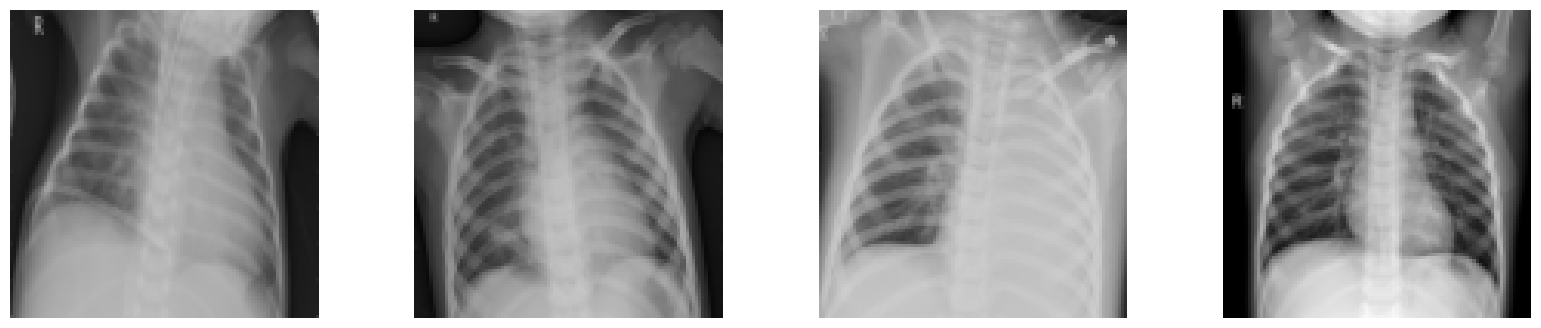

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def image_show(train_loader, num_images=4):
    
    images, labels = next(iter(train_loader))


    fig, axes = plt.subplots(1, num_images, figsize=(20, 4)) 

    for i in range(num_images):
        ax = axes[i]
        img = np.transpose(images[i].numpy(), (1, 2, 0))  
        ax.imshow(img)
        ax.axis('off')  

    plt.show()

image_show(train_loader, num_images=4)


In [7]:
test_data = datasets.ImageFolder(test_data_path,transform=transform)

In [8]:
test_loader = torch.utils.data.DataLoader(test_data,batch_size=4,shuffle=True)

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.var = nn.Linear(hidden_dim, z_dim)

    def forward(self, x, skip_batch_norm=False):
        if skip_batch_norm:
            hidden = F.relu(self.linear(x))
        else:
            hidden = F.relu(self.bn(self.linear(x)))
        z_mu = self.mu(hidden)
        z_var = self.var(hidden)
        return z_mu, z_var

In [10]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, skip_batch_norm=False):
        if skip_batch_norm:
            hidden = F.relu(self.linear(x))
        else:
            hidden = F.relu(self.bn(self.linear(x)))
        predicted = torch.sigmoid(self.out(hidden))
        return predicted

In [11]:
class VAE(nn.Module):

        def __init__(self, enc, dec):
            super().__init__()

            self.enc = enc
            self.dec = dec

        def forward(self, x, skip_batch_norm=False):
            # encode
            z_mu, z_var = self.enc(x)

            std = torch.exp(z_var / 2)
            eps = torch.randn_like(std)
            x_sample = eps.mul(std).add_(z_mu)

            # decode
            predicted = self.dec(x_sample, skip_batch_norm)
            return predicted, z_mu, z_var

In [12]:
device = torch.device("mps")
# encoder = Encoder(3*100*100, 256, 20)
encoder = Encoder(3*100*100, 256, 30)

# decoder = Decoder(20, 256, 3*100*100)
decoder = Decoder(30, 256, 3*100*100)
model = VAE(encoder, decoder)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
import torch
import torch.nn.functional as F
from torch import optim
from torchvision import transforms

best_test_loss = float('inf')
patience_counter = 0
patience_limit = 3  # Early stopping patience

for epoch in range(50):
    train_loss = 0
    test_loss = 0
    print(f'Started Epoch {epoch}')

    for img, _ in train_loader:
        img = img.view(-1, 3 * 100 * 100)  
        optimizer.zero_grad()
        img_sample, z_mu, z_var = model(img)
        recon_loss = F.binary_cross_entropy(img_sample, img, reduction='sum')
        kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
        loss = recon_loss + kl_loss
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    
    with torch.no_grad():
        for img, _ in test_loader:
            img = img.view(-1, 3 * 100 * 100)
            img_sample, z_mu, z_var = model(img)
            recon_loss = F.binary_cross_entropy(img_sample, img, reduction='sum')
            kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
            loss = recon_loss + kl_loss
            test_loss += loss.item()

    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    print(f'Epoch {epoch}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')

    # Early Stopping Check
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience_limit:
        print("Early stopping triggered")
        break


Started Epoch 0
Epoch 0, Train Loss: 72356.69, Test Loss: 71725.40
Started Epoch 1
Epoch 1, Train Loss: 71691.90, Test Loss: 71429.63
Started Epoch 2
Epoch 2, Train Loss: 71517.64, Test Loss: 71316.81
Started Epoch 3
Epoch 3, Train Loss: 71423.70, Test Loss: 71306.20
Started Epoch 4
Epoch 4, Train Loss: 71353.85, Test Loss: 71164.14
Started Epoch 5
Epoch 5, Train Loss: 71297.00, Test Loss: 71153.42
Started Epoch 6
Epoch 6, Train Loss: 71252.79, Test Loss: 71226.39
Started Epoch 7
Epoch 7, Train Loss: 71249.85, Test Loss: 71129.88
Started Epoch 8
Epoch 8, Train Loss: 71203.55, Test Loss: 71216.51
Started Epoch 9
Epoch 9, Train Loss: 71215.13, Test Loss: 71112.48
Started Epoch 10
Epoch 10, Train Loss: 71151.75, Test Loss: 71075.97
Started Epoch 11
Epoch 11, Train Loss: 71162.19, Test Loss: 71007.27
Started Epoch 12
Epoch 12, Train Loss: 71125.24, Test Loss: 70996.53
Started Epoch 13
Epoch 13, Train Loss: 71121.43, Test Loss: 71053.72
Started Epoch 14
Epoch 14, Train Loss: 71087.62, Test 

## Generated images

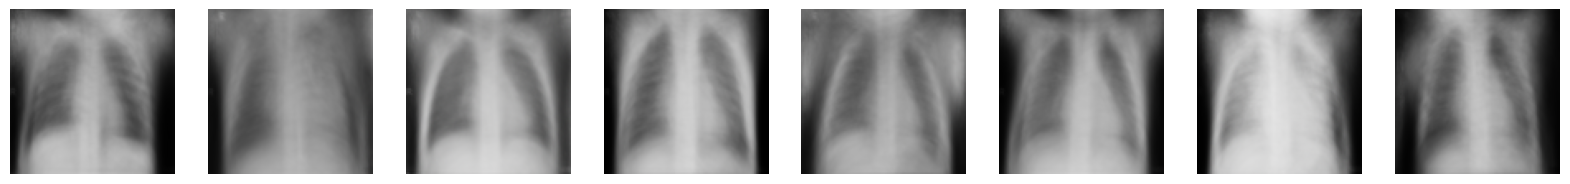

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def show_generated_images(model, num_images=8, z_dim=20):
    
    z = torch.randn(num_images, z_dim)
    
    with torch.no_grad():
        
        generated_images = model.dec(z).cpu()

    generated_images = generated_images.view(-1, 3, 100, 100)  
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))

    for i, img in enumerate(generated_images):
        ax = axes[i]
        img = img.numpy().transpose(1, 2, 0)  
        ax.imshow(img, cmap='gray')  
        ax.axis('off')

    plt.show()

show_generated_images(model, num_images=8, z_dim=30)


## Image transform using vector

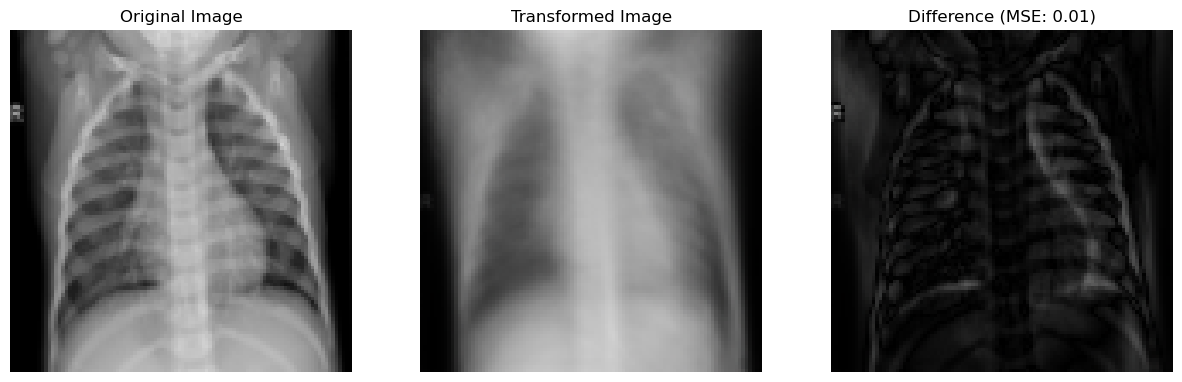

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_image_transformation(model, data_loader, z_dim=20, change_dim=None, change_val=5):
    model.eval()  

    imgs, _ = next(iter(data_loader))
    imgs = imgs.view(-1, 3 * 100 * 100)  

    with torch.no_grad():
        z_mu, _ = model.enc(imgs)

    if change_dim is not None:
        z_mu[0][change_dim] += change_val

    with torch.no_grad():
        transformed_imgs = model.dec(z_mu).cpu()

    original_img = imgs[0].view(3, 100, 100).numpy().transpose(1, 2, 0)
    transformed_img = transformed_imgs[0].view(3, 100, 100).numpy().transpose(1, 2, 0)

    difference = np.abs(original_img - transformed_img)
    mse = np.mean((original_img - transformed_img) ** 2)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(original_img, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(transformed_img, cmap='gray')
    axes[1].set_title('Transformed Image')
    axes[1].axis('off')

    axes[2].imshow(difference, cmap='gray')
    axes[2].set_title(f'Difference (MSE: {mse:.2f})')
    axes[2].axis('off')
    
    plt.show()


visualize_image_transformation(model, test_loader, z_dim=30, change_dim=2, change_val=5)
